## Reduced Rank Regression

In [1]:
import os
import pickle as pkl
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from utils.helpers import *

# autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
# Load the data
current_dir = os.getcwd()
print("Loading the data...")
data_path = os.path.join(current_dir, 'data')
data = load_data(data_path, 'ssp585_time_series.pkl')
print("Data loaded successfully!")

Loading the data...
Data loaded successfully!


In [3]:
filtered_data = filter_data(data)

100%|██████████| 72/72 [00:00<00:00, 77176.05it/s]


In [4]:
# Print the shape of the first run in the first model of filtered_data
first_model = list(filtered_data.keys())[0]
first_run = list(filtered_data[first_model].keys())[0]
print(f"Shape of the first run in the first model: {filtered_data[first_model][first_run].shape}")

Shape of the first run in the first model: (165, 72, 144)


In [5]:
# Create a NaN mask to remove any cells which have 1 >= NaNs

nan_mask = create_nan_mask(filtered_data)

100%|██████████| 34/34 [00:02<00:00, 15.55it/s]


In [6]:
# Apply the NaN mask to every single run (modifications done in place for memory efficiency)

masked_data = mask_out_nans(filtered_data, nan_mask)

100%|██████████| 34/34 [00:01<00:00, 26.36it/s]


In [7]:
# Print the shape of the first run in the first model of masked_data
first_model = list(masked_data.keys())[0]
first_run = list(masked_data[first_model].keys())[0]
print(f"Shape of the first run in the first model: {masked_data[first_model][first_run].shape}")

Shape of the first run in the first model: (165, 72, 144)


## The NaN mask has been applied and only the models with more than 4 runs have been kept

In [8]:
print(f"There are exactly {len(masked_data.keys())} models of the {len(data.keys())} that remain.")

There are exactly 34 models of the 72 that remain.


In [9]:
reshaped_data = reshape_data(masked_data)

100%|██████████| 34/34 [00:04<00:00,  8.23it/s]


In [10]:
example_model = 'CanESM5-1'
example_model_data = reshaped_data[example_model]
print(f"Selected model: {example_model}, which has {len(example_model_data)} runs.")

Selected model: CanESM5-1, which has 72 runs.


In [11]:
first_example_model_run = example_model_data[list(example_model_data.keys())[0]]
first_example_model_run.shape # Shape: (Time x (Latitude x Longitude))

(165, 10368)

### Calculate the forced response for each model, assuming that it is the mean of all the runs

In [12]:
data_forced_responses = add_forced_response(reshaped_data) # The forced response is not correctly normalized yet (this is done by the normalize function below)

  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:04<00:00,  7.69it/s]


In [13]:
# Print the shape of a random run from a random model

random_model = random.choice(list(data_forced_responses.keys()))
random_run = random.choice(list(data_forced_responses[random_model].keys()))
print(f"Shape of the random run: {data_forced_responses[random_model][random_run].shape}")

Shape of the random run: (165, 10368)


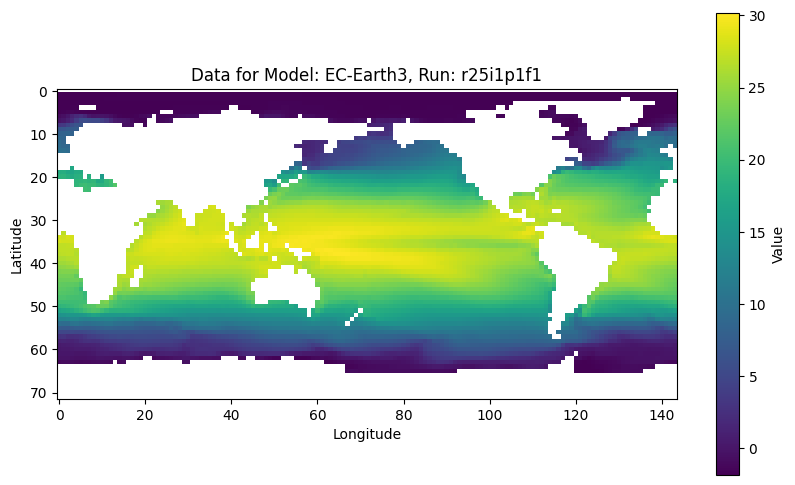

In [14]:
# Reshape the data to the original grid shape
data_grid = data_forced_responses[random_model][random_run][0].reshape(72, 144)

# Plot the data using plt.imshow
plt.figure(figsize=(10, 6))
plt.imshow(data_grid, cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Data for Model: {random_model}, Run: {random_run}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## At this point, the data still contains NaNs, corresponding to the continents

In [15]:
data_without_nans = remove_nans_from_grid(data_forced_responses, nan_mask)

100%|██████████| 34/34 [00:01<00:00, 20.07it/s]


In [16]:
# Print the shape of a random run from a random model (same as above)
print(f"The shape of the data without NaNs: {data_without_nans[random_model][random_run].shape}")

The shape of the data without NaNs: (165, 6523)


## Now the NaNs have been completely removed from the data

### The data is now in the shape : Time x # of grid cells without NaNs

In [17]:
# Select one of the models randomly for testing and the rest for training according to the leave-one-out strategy
test_model = random.choice(list(data_without_nans.keys()))
train_models = [model for model in data_without_nans.keys() if model != test_model]

# Create the training and testing datasets
train_data = {model: data_without_nans[model] for model in train_models}
test_data = {test_model: data_without_nans[test_model]}

print(f"Training models: {train_models}")
print(f"Testing model: {test_model}")

Training models: ['ICON-ESM-LR', 'EC-Earth3', 'CMCC-CM2-SR5', 'ACCESS-CM2', 'CESM2', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'GISS-E2-2-G', 'CNRM-CM6-1', 'CanESM5-1', 'E3SM-2-0-NARRM', 'HadGEM3-GC31-LL', 'MIROC-ES2L', 'GISS-E2-1-H', 'E3SM-2-0', 'GISS-E2-1-G', 'EC-Earth3-Veg', 'ACCESS-ESM1-5', 'HadGEM3-GC31-MM', 'FGOALS-g3', 'E3SM-1-0', 'MPI-ESM1-2-HR', 'CanESM5', 'CAS-ESM2-0', 'MIROC6', 'NESM3', 'GISS-E2-2-H', 'MPI-ESM1-2-LR', 'UKESM1-0-LL', 'NorCPM1', 'INM-CM5-0', 'MRI-ESM2-0', 'CESM2-FV2']
Testing model: AWI-CM-1-1-MR


In [18]:
# Normalize the data
normalized_train_data, normalized_test_data, training_statistics, testing_statistics = normalize_data(train_data, test_data)

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


Normalizing test data for model AWI-CM-1-1-MR
Data normalization completed.


Selected model: CNRM-ESM2-1, run: forced_response.
Shape of the normalized data: (165, 6523).
Shape of the original data: (165, 6523).


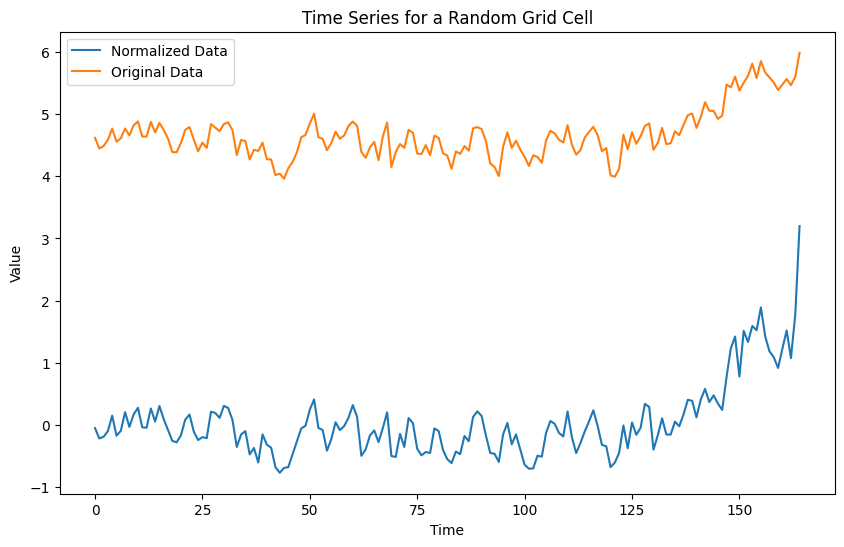

In [85]:
# make a few plots using normalized_train_data and train_data by selecting a random grid cell and plotting the time series
random_model = random.choice(list(normalized_train_data.keys()))
random_run = random.choice(list(normalized_train_data[random_model].keys()))

print(f"Selected model: {random_model}, run: {random_run}.")

# print dimensions of the data
print(f"Shape of the normalized data: {normalized_train_data[random_model][random_run].shape}.")
print(f"Shape of the original data: {train_data[random_model][random_run].shape}.")

# select a random grid cell
random_cell = random.randint(0, 6523)
time_series_normalized = normalized_train_data[random_model][random_run][:, random_cell]
time_series_original = train_data[random_model][random_run][:, random_cell]

# plot the time series
plt.figure(figsize=(10, 6))
plt.plot(time_series_normalized, label='Normalized Data')
plt.plot(time_series_original, label='Original Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series for a Random Grid Cell')
plt.legend()
plt.show()

## Now that the data has been normalized (and NaN values removed), it's time to do the Reduced Rank Regression (RRR)

In [86]:
# First pool the data together
X_full, Y_full = pool_data(normalized_train_data)

100%|██████████| 33/33 [00:00<00:00, 173666.29it/s]


In [87]:
X_full.shape, Y_full.shape # Shape is correct

((122925, 6523), (122925, 6523))

In [88]:
rank = 10 # Used as a starting point
lambda_ = 0.01 # This will be optimized later
Brr, B_ols = reduced_rank_regression(X_full, Y_full, rank, lambda_)

In [89]:
# print mean and std of X_full and Y_full

print(f"Mean of X_full: {np.mean(X_full)}")
print(f"Std of X_full: {np.std(X_full)}")
print(f"Mean of Y_full: {np.mean(Y_full)}")
print(f"Std of Y_full: {np.std(Y_full)}")

Mean of X_full: -0.19605488613222224
Std of X_full: 13.018606832588624
Mean of Y_full: -0.19605488613222027
Std of Y_full: 12.980143445337017


In [90]:
Brr.shape, B_ols.shape

((6523, 6523), (6523, 6523))

In [160]:
# Test a prediction on the test set for a single run

# Select a random run from the test set
test_model = list(normalized_test_data.keys())[0]
test_runs = [run for run in normalized_test_data[test_model].keys() if run != 'forced_response']
test_run = normalized_test_data[test_model][random.choice(test_runs)]
ground_truth = normalized_test_data[test_model]['forced_response']

In [161]:
test_run.shape, ground_truth.shape

((165, 6523), (165, 6523))

In [162]:
# make the prediction

prediction = test_run @ B_ols # use test_run @ B_ols for the OLS prediction
prediction.shape

(165, 6523)

In [163]:
# Add the NaN values back to the correct spots
predictions = True
prediction = readd_nans_to_grid(prediction, nan_mask, predictions)
test_run = readd_nans_to_grid(test_run, nan_mask, predictions)
ground_truth = readd_nans_to_grid(ground_truth, nan_mask, predictions)

In [164]:
prediction.shape, test_run.shape, ground_truth.shape

((165, 10368), (165, 10368), (165, 10368))

In [165]:
prediction.shape, test_run.shape, ground_truth.shape

((165, 10368), (165, 10368), (165, 10368))

Displaying the forced response and runs for grid spot: [54  3]


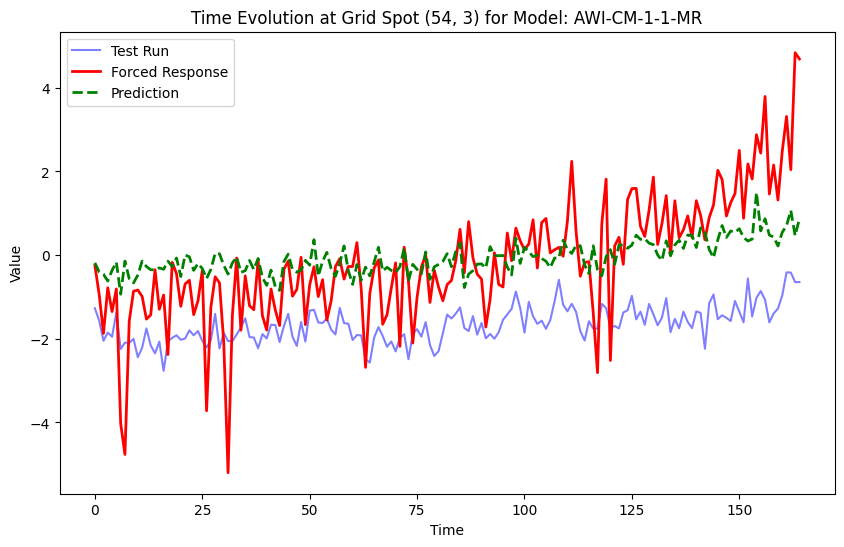

In [176]:
# Select a random grid spot
valid_grid_spots = np.argwhere(~nan_mask)
random_grid_spot = valid_grid_spots[random.randint(0, len(valid_grid_spots))]
print(f"Displaying the forced response and runs for grid spot: {random_grid_spot}")

# Data for each run (minus the forced response)
input_data = test_run.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]
# Data for the forced response
forced_response_data = ground_truth.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]
# Data for the prediction
predicted_data = prediction.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]

# Plot the time series data for all runs, the forced response, and the prediction
plt.figure(figsize=(10, 6))
plt.plot(input_data, color='blue', alpha=0.5, label='Test Run')
plt.plot(forced_response_data, color='red', label='Forced Response', linewidth=2)
plt.plot(predicted_data, color='green', label='Prediction', linewidth=2, linestyle='--')
plt.title(f'Time Evolution at Grid Spot ({random_grid_spot[0]}, {random_grid_spot[1]}) for Model: {test_model}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [98]:
print(f"The shape of the data is: {X_full.shape}")
print(f"The shape of the target is: {Y_full.shape}")
print(f"The maximum, minimum, average and std for the input data are: {np.max(X_full)}, {np.min(X_full)}, {np.mean(X_full)}, {np.std(X_full)}")
print(f"The maximum, minimum, average and std for the target data are: {np.max(Y_full)}, {np.min(Y_full)}, {np.mean(Y_full)}, {np.std(Y_full)}")

The shape of the data is: (122925, 6523)
The shape of the target is: (122925, 6523)
The maximum, minimum, average and std for the input data are: 167.02204344403054, -7610.598601598949, -0.19605488613222224, 13.018606832588624
The maximum, minimum, average and std for the target data are: 165.4961780244595, -7608.745755742709, -0.19605488613222027, 12.980143445337017


Random timestamp: 4


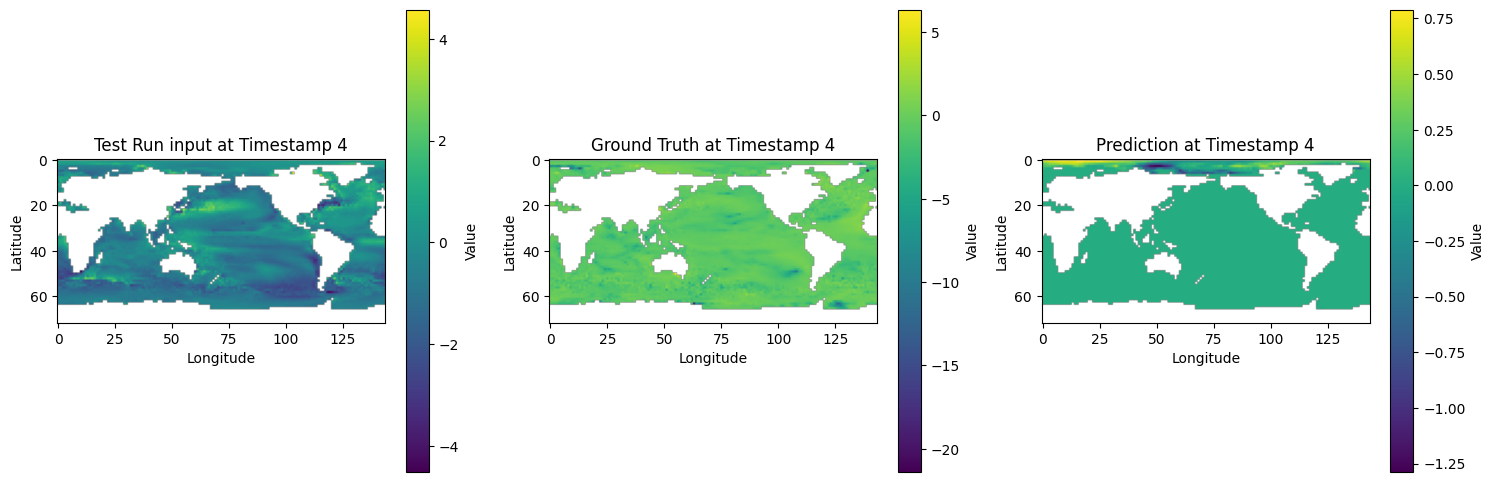

In [99]:
# Plot a random timestamp for the target and prediction

random_timestamp = random.randint(0, prediction.shape[0])
print(f"Random timestamp: {random_timestamp}")

# Data for the target
# Reshape the data to the original grid shape
test_run_grid = test_run[random_timestamp, :].reshape(72, 144)
ground_truth_grid = ground_truth[random_timestamp, :].reshape(72, 144)
prediction_grid = prediction[random_timestamp, :].reshape(72, 144)

# Plot the data using plt.imshow
plt.figure(figsize=(18, 6))

# Plot the test run
plt.subplot(1, 3, 1)
plt.imshow(test_run_grid, cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Test Run input at Timestamp {random_timestamp}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot the ground truth (forced response)
plt.subplot(1, 3, 2)
plt.imshow(ground_truth_grid, cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Ground Truth at Timestamp {random_timestamp}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot the prediction
plt.subplot(1, 3, 3)
plt.imshow(prediction_grid, cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Prediction at Timestamp {random_timestamp}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [100]:
# Calculate the MSE of the predictions vs the ground truth
prediction.shape, ground_truth.shape

((165, 10368), (165, 10368))

## Compute the MSE for each of the runs using the RRR

In [179]:
normalized_test_data.keys()

dict_keys(['AWI-CM-1-1-MR'])

Model: AWI-CM-1-1-MR, Run: r1i1p1f1, MSE: 2.042740146251127
Model: AWI-CM-1-1-MR, Run: r2i1p1f1, MSE: 2.0438773233196095
Model: AWI-CM-1-1-MR, Run: r3i1p1f1, MSE: 2.0415648310573435
Model: AWI-CM-1-1-MR, Run: r4i1p1f1, MSE: 2.0443543014656638
Model: AWI-CM-1-1-MR, Run: r5i1p1f1, MSE: 2.0450064229377163


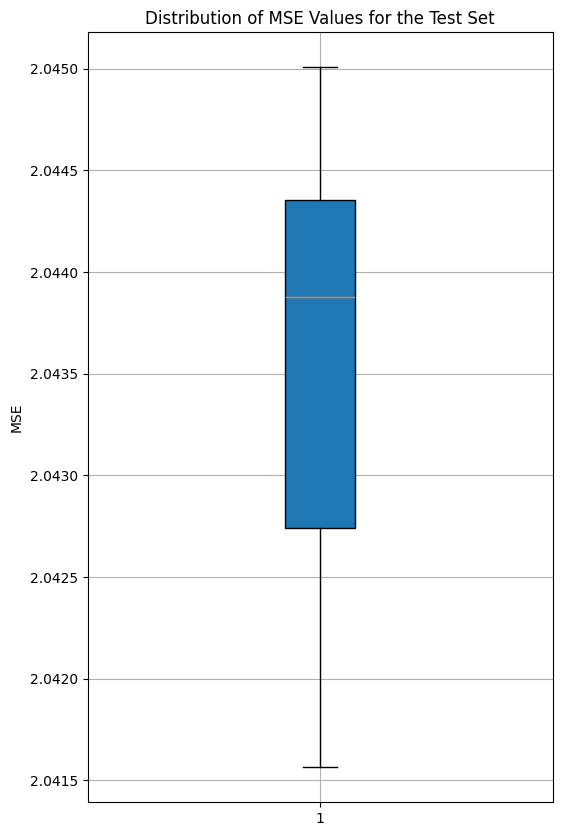

In [181]:
# Calculate the MSE for each of the runs in the test set

test_model_mse = []
for model in normalized_test_data:
    for run in normalized_test_data[model]:
        if run == 'forced_response':
            continue
        test_run = normalized_test_data[model][run]
        ground_truth = normalized_test_data[model]['forced_response']
        run_mse = calculate_mse(test_run, Brr, ground_truth)
        test_model_mse.append(run_mse)
        print(f"Model: {model}, Run: {run}, MSE: {run_mse}")
        
# Plot the distribution of the MSE values
plt.figure(figsize=(6, 10))
plt.boxplot(test_model_mse, vert=True, patch_artist=True)
plt.ylabel('MSE')
plt.title('Distribution of MSE Values for the Test Set')
plt.grid(True)
plt.show()